# GP doctors per LAD

In [1]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [2]:
#|export
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import os,glob

from sklearn import linear_model

#from dementia_inequalities.tools.health_helpers import polygon_area 

---

## Load the relevant dataframes 

In [3]:
# Load data about intersections of GP catchment areas and LAD
df_LAD_GP_pop = pd.read_csv(const.pre_output_path+'/LAD_GP_area_intersections.csv')

# Loads data of GP counts 
df_GP_count = pd.read_csv(const.data_path+'/GP_practices_dec_23/gp_Count.csv')

In [4]:
df_GP_count.head()

,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,BARTS HEALTH NHS TRUST,R1H00,BARTS HEALTH NHS TRUST CHS,"BEAUMONT HOUSE, ROOM 31, MILE END HOSPITAL, LO...",Y05462,1,NaN,NaN,NaN
1,BEXLEY HEALTH NEIGHBOURHOOD CARE,DFJ00,GUARD YOUR HEART HUB,"C/O BELLGROVE SURGERY, 174 BELLGROVE ROAD, WEL...",Y08001,1,NaN,NaN,NaN
2,BMI HEALTHCARE,NT400,BMI BEAUMONT HOSPITAL,"OLD HALL CLOUGH, CHORLEY NEW ROAD LOSTOCK, BOL...",Y06646,1,NaN,NaN,NaN
3,BMI HEALTHCARE,NT400,BMI BISHOPSWOOD HOSPITAL,"RICKMANSWORTH ROAD, NORTHWOOD, MIDDLESEX, HA6 2JW",Y06603,1,NaN,NaN,NaN
4,BMI HEALTHCARE,NT400,BMI CHAUCER HOSPITAL,"NACKINGTON ROAD, CANTERBURY, KENT, CT4 7AR",Y04413,1,NaN,NaN,NaN


In [5]:
list_gps = df_LAD_GP_pop['gp_name'].values
list_gps_codes = [item[0:6] for item in list_gps]

df_LAD_GP_pop['GP_code'] = list_gps_codes

In [6]:
df_LAD_GP_count = pd.merge(df_LAD_GP_pop, df_GP_count, left_on='GP_code', right_on='Code.1', how='left')

In [7]:
df_LAD_GP_count.head()

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code,Comm./Prov.,Code,Practice Name,Practice Address,Code.1,GP Count,Dispensing List Size,Prescribing List Size,Total List Size
0,0,7228,154.810845,51241.009004,Hartlepool,279.802173,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE,167.919513,167.919513,0.921935,A81070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1607,168.866010,55893.143290,Hartlepool,279.802173,A81622 - GLADSTONE HOUSE SURGERY,172.166251,172.166251,0.980831,A81622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7219,185.284987,61327.677980,Hartlepool,279.802173,A81060 - THE KOH PRACTICE,207.778224,207.778224,0.891744,A81060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7959,189.603022,62756.909149,Hartlepool,279.802173,A81044 - MCKENZIE HOUSE SURGERY,193.364841,193.364841,0.980545,A81044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2654,214.436151,70976.453448,Hartlepool,279.802173,A81007 - BANKHOUSE SURGERY,226.560820,226.560820,0.946484,A81007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_LAD_GP_count['GP_contribution_to_LAD'] = df_LAD_GP_count['percent_GP_in_LAD']*df_LAD_GP_count['GP Count']

In [9]:
# tidy up the dataframe a bit before saving it 
df_LAD_GP = df_LAD_GP_count[['LAD_name', 'GP_code', 'gp_name', 'intersection_size', 'intersection_pop', 'percent_GP_in_LAD', 'GP Count', 'GP_contribution_to_LAD']]

df_LAD_GP = df_LAD_GP.drop_duplicates()
df_LAD_GP.reset_index(inplace=True, drop=True)

df_LAD_GP.columns = ['LAD_name', 'GP_code', 'GP_name', 'area_intersection', 'pop_intersection', 'percent_GP_in_LAD', 'GP_count_practice', 'GP_contribution_to_LAD']

## Number of GPs in each LAD 

In [10]:
df_LAD_GP = df_LAD_GP.fillna(0)
df_GP_contribution = df_LAD_GP.groupby('LAD_name').sum()
df_GP_contribution.reset_index(inplace=True)
df_GP_contribution = df_GP_contribution[['LAD_name', 'GP_contribution_to_LAD']]

non_zero_gp_cont = len(df_GP_contribution[df_GP_contribution["GP_contribution_to_LAD"]>0])
print(f'Only have GP counts for {non_zero_gp_cont} of the 309 LADs.')

Only have GP counts for 50 of the 309 LADs.


In [11]:
df_GP_contribution[df_GP_contribution["GP_contribution_to_LAD"]>0]

,LAD_name,GP_contribution_to_LAD
7,Barking and Dagenham,259.203969
8,Barnet,643.138983
16,Bexley,164.887841
29,Brent,291.555031
30,Brentwood,0.267655
34,Bromley,350.447850
36,Broxbourne,0.066319
43,Camden,557.177948
58,City of London,20.901767
67,Croydon,529.704268


In [12]:
df_LAD_GP

,LAD_name,GP_code,GP_name,area_intersection,pop_intersection,percent_GP_in_LAD,GP_count_practice,GP_contribution_to_LAD
0,Hartlepool,A81070,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE,154.810845,51241.009004,0.921935,0.0,0.000000
1,Hartlepool,A81622,A81622 - GLADSTONE HOUSE SURGERY,168.866010,55893.143290,0.980831,0.0,0.000000
2,Hartlepool,A81060,A81060 - THE KOH PRACTICE,185.284987,61327.677980,0.891744,0.0,0.000000
3,Hartlepool,A81044,A81044 - MCKENZIE HOUSE SURGERY,189.603022,62756.909149,0.980545,0.0,0.000000
4,Hartlepool,A81007,A81007 - BANKHOUSE SURGERY,214.436151,70976.453448,0.946484,0.0,0.000000
...,...,...,...,...,...,...,...,...
15166,Westminster,E87026,E87026 - MEANWHILE GARDEN MEDICAL CENTRE,12.274104,45040.765372,0.463457,2.0,0.926915
15167,Westminster,E87701,E87701 - THE ABINGDON HEALTH CENTRE,0.000029,0.106191,0.000004,8.0,0.000032
15168,Westminster,F83048,F83048 - BRUNSWICK MEDICAL CENTRE UHPC,0.084800,311.181309,0.005763,19.0,0.109504
15169,Westminster,F83058,F83058 - HOLBORN MEDICAL CENTRE,0.008687,31.875834,0.004101,14.0,0.057411


In [13]:
# number of GP's with at least cut_off amount of catchment area in the LAD
LAD_names = df_LAD_GP['LAD_name'].unique()
cut_off = 0.3

for lad in LAD_names:
    df_LAD = df_LAD_GP[df_LAD_GP['LAD_name']==lad]
    num_GPs = len(df_LAD[df_LAD['percent_GP_in_LAD']>cut_off])
    print(f'{lad}:{num_GPs}')

Hartlepool:16
Middlesbrough:30
Redcar and Cleveland:25
Stockton-on-Tees:65
Darlington:17
Halton:49
Warrington:50
Blackburn with Darwen:31
Blackpool:25
Kingston upon Hull, City of:42
East Riding of Yorkshire:54
North East Lincolnshire:26
North Lincolnshire:23
York:13
Derby:37
Leicester:65
Rutland:5
Nottingham:58
Herefordshire, County of:33
Telford and Wrekin:16
Stoke-on-Trent:62
Bath and North East Somerset:30
Bristol, City of:48
North Somerset:13
South Gloucestershire:37
Plymouth:48
Torbay:14
Swindon:26
Peterborough:16
Luton:30
Southend-on-Sea:33
Thurrock:37
Medway:43
Bracknell Forest:20
West Berkshire:20
Reading:37
Slough:23
Windsor and Maidenhead:46
Wokingham:39
Milton Keynes:36
Brighton and Hove:49
Portsmouth:20
Southampton:53
Isle of Wight:15
County Durham:66
Cheshire East:32
Cheshire West and Chester:43
Shropshire:51
Cornwall:63
Isles of Scilly:0
Wiltshire:57
Bedford:23
Central Bedfordshire:35
Northumberland:46
Bournemouth, Christchurch and Poole:72
Dorset:57
Buckinghamshire:65
No

## Save data

In [14]:
df_LAD_GP.to_csv(const.output_path+'/GP_LAD_inter_GP_count.csv', index=False)

## Look at GP distribution across practices

In [15]:
df_QOF_prev = pd.read_csv(const.data_path+'/QOF_2122_V2/PREVALENCE_2122_V2.csv')

In [16]:
# Only interested in Dementia diagnosis 
df_QOF_dem = df_QOF_prev[df_QOF_prev['GROUP_CODE']=='DEM'].copy()
# Drop columns which are not useful 
df_QOF_dem.drop(labels=['GROUP_CODE', 'PATIENT_LIST_TYPE'], axis=1, inplace=True)
df_QOF_dem.rename(columns={'REGISTER':'DEM_REGISTER'}, inplace=True)
df_QOF_dem.head()

,PRACTICE_CODE,DEM_REGISTER,PRACTICE_LIST_SIZE
6,A81001,26.0,4045
27,A81002,205.0,18490
48,A81004,100.0,11104
69,A81005,92.0,8082
90,A81006,144.0,14534


In [17]:
df_QOF_dem = pd.merge(df_QOF_dem, df_GP_count[['Code.1', 'GP Count']], left_on='PRACTICE_CODE', right_on='Code.1', how='left')
df_QOF_dem.drop(columns='Code.1', inplace=True)
with_GP_count = df_QOF_dem[df_QOF_dem['GP Count']>0]
with_no_GP_count = df_QOF_dem[~(df_QOF_dem['GP Count']>0)]

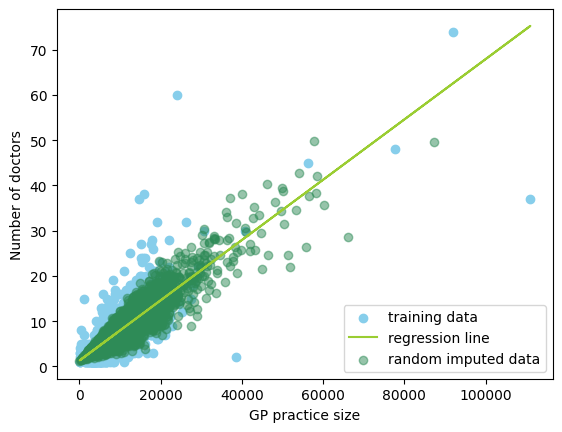

In [18]:
# Random regression imputation with heteroskedastic error term 

# Remove datapoints where the number of doctors is over 2 deviations away from the mean
#GP_mean = np.mean(with_GP_count['GP Count'].values)
#GP_std = np.std(with_GP_count['GP Count'].values)
#GP_upper_lim = GP_mean + 3*GP_std

#with_GP_no_outliers = with_GP_count[with_GP_count['GP Count']<GP_upper_lim]

# original
x_orig = with_GP_count['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
y_orig =  with_GP_count['GP Count'].values.reshape(-1,1)

# with outliers removed 
#x = with_GP_no_outliers['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
#y =  with_GP_no_outliers['GP Count'].values.reshape(-1,1)

# test dataset
x_test = with_no_GP_count['PRACTICE_LIST_SIZE'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
#regr.fit(x, y)
regr.fit(x_orig, y_orig)
#y_pred = regr.predict(x)
y_pred = regr.predict(x_orig)

# calculate std of variance 
resid_std = np.std(np.abs(y_orig-y_pred))
#noise = np.random.normal(loc=0.0, scale=resid_std, size=len(x_test))
hetero_noise = 0.00005*np.abs(x_test) * np.random.normal(loc=0, scale=resid_std, size=x_test.shape)

test_y_pred = regr.predict(x_test)
#test_y_pred_noise = test_y_pred + np.arange(len(x_test))*noise.reshape(-1,1)
test_y_pred_noise = test_y_pred + hetero_noise.reshape(-1,1)

plt.scatter(x_orig, y_orig, color = 'skyblue')
plt.plot(x_orig, y_pred, color='yellowgreen')
plt.scatter(x_test, test_y_pred_noise, color='seagreen', alpha=0.5)
plt.xlabel('GP practice size')
plt.ylabel('Number of doctors')
plt.legend(['training data', 'regression line', 'random imputed data'], loc='lower right')

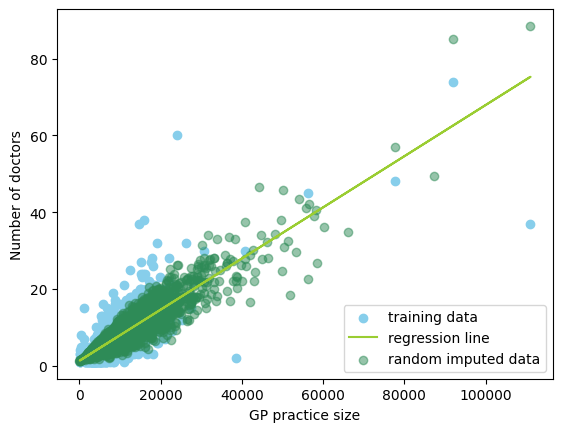

In [19]:
# Random regression imputation with heteroskedastic error term 

# Remove datapoints where the number of doctors is over 2 deviations away from the mean
#GP_mean = np.mean(with_GP_count['GP Count'].values)
#GP_std = np.std(with_GP_count['GP Count'].values)
#GP_upper_lim = GP_mean + 3*GP_std

#with_GP_no_outliers = with_GP_count[with_GP_count['GP Count']<GP_upper_lim]

# original
x = df_QOF_dem['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
#y_orig =  df_QOF_dem['GP Count'].values.reshape(-1,1)

# original
x_train = with_GP_count['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
y_train =  with_GP_count['GP Count'].values.reshape(-1,1)

# with outliers removed 
#x = with_GP_no_outliers['PRACTICE_LIST_SIZE'].values.reshape(-1,1)
#y =  with_GP_no_outliers['GP Count'].values.reshape(-1,1)

# test dataset
#x_test = with_no_GP_count['PRACTICE_LIST_SIZE'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression
#regr.fit(x, y)
regr.fit(x_train, y_train)
#y_pred = regr.predict(x)
y_pred = regr.predict(x_train)

test_y_pred = regr.predict(x)

# calculate std of variance 
resid_std = np.std(np.abs(y_train-y_pred))
#noise = np.random.normal(loc=0.0, scale=resid_std, size=len(x_test))
hetero_noise = 0.00005*np.abs(x) * np.random.normal(loc=0, scale=resid_std, size=x.shape)

#test_y_pred_noise = test_y_pred + np.arange(len(x_test))*noise.reshape(-1,1)
y = test_y_pred + hetero_noise.reshape(-1,1)

plt.scatter(x_train, y_train, color = 'skyblue')
plt.plot(x_train, y_pred, color='yellowgreen')
plt.scatter(x, y, color='seagreen', alpha=0.5)
plt.xlabel('GP practice size')
plt.ylabel('Number of doctors')
plt.legend(['training data', 'regression line', 'random imputed data'], loc='lower right')

In [20]:
df_QOF_dem['GP_count_random_imputed_missing'] = y

In [21]:
df_QOF_dem.head()

,PRACTICE_CODE,DEM_REGISTER,PRACTICE_LIST_SIZE,GP Count,GP_count_random_imputed_missing
0,A81001,26.0,4045,NaN,4.485095
1,A81002,205.0,18490,NaN,13.307300
2,A81004,100.0,11104,NaN,9.470958
3,A81005,92.0,8082,NaN,6.225897
4,A81006,144.0,14534,NaN,8.744099


In [22]:
df_QOF_dem['GP_count_regression_imputed'] = df_QOF_dem['GP Count']
df_QOF_dem['GP_count_regression_imputed'].fillna(df_QOF_dem['GP_count_random_imputed_missing'], inplace=True)
df_QOF_dem.drop(columns='GP_count_random_imputed_missing')

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_8503/2319437671.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_QOF_dem['GP_count_regression_imputed'].fillna(df_QOF_dem['GP_count_random_imputed_missing'], inplace=True)


,PRACTICE_CODE,DEM_REGISTER,PRACTICE_LIST_SIZE,GP Count,GP_count_regression_imputed
0,A81001,26.0,4045,NaN,4.485095
1,A81002,205.0,18490,NaN,13.307300
2,A81004,100.0,11104,NaN,9.470958
3,A81005,92.0,8082,NaN,6.225897
4,A81006,144.0,14534,NaN,8.744099
...,...,...,...,...,...
6465,Y07020,254.0,539,8.0,8.000000
6466,Y07025,70.0,9544,NaN,9.350243
6467,Y07057,63.0,11797,NaN,5.343258
6468,Y07059,118.0,19561,NaN,17.845966


Text(0, 0.5, 'Number of doctors')

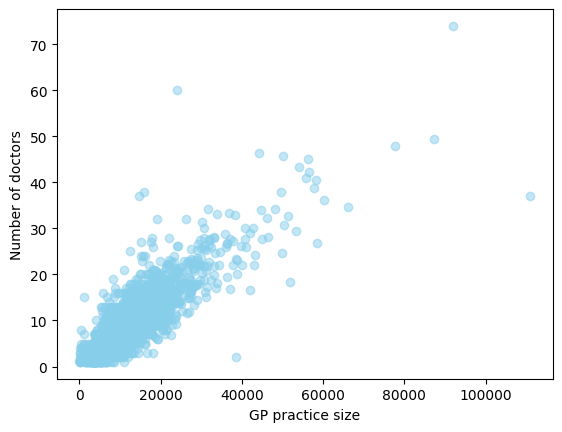

In [23]:
plt.scatter(df_QOF_dem['PRACTICE_LIST_SIZE'], df_QOF_dem['GP_count_regression_imputed'], color='skyblue', alpha=0.5)
plt.xlabel('GP practice size')
plt.ylabel('Number of doctors')

## Contribution of GP doctors to each LAD 

In [24]:
df_LAD_GP_count = pd.merge(df_LAD_GP_pop, df_QOF_dem[['PRACTICE_CODE', 'GP_count_regression_imputed']], left_on='GP_code', right_on='PRACTICE_CODE', how='right')

In [25]:
df_LAD_GP_count['GP_contribution_to_LAD'] = df_LAD_GP_count['percent_GP_in_LAD']*df_LAD_GP_count['GP_count_regression_imputed']

In [26]:
# tidy up the dataframe a bit before saving it 
df_LAD_GP = df_LAD_GP_count[['LAD_name', 'GP_code', 'gp_name', 'intersection_size', 'intersection_pop', 'percent_GP_in_LAD', 'GP_count_regression_imputed', 'GP_contribution_to_LAD']]

df_LAD_GP.reset_index(inplace=True, drop=True)

df_LAD_GP.columns = ['LAD_name', 'GP_code', 'GP_name', 'area_intersection', 'pop_intersection', 'percent_GP_in_LAD', 'GP_count_practice_imputed', 'GP_contribution_to_LAD']

In [27]:
df_LAD_GP_count[df_LAD_GP_count['percent_GP_in_LAD']<0]

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code,PRACTICE_CODE,GP_count_regression_imputed,GP_contribution_to_LAD


In [28]:
df_GP_contribution = df_LAD_GP.groupby('LAD_name').sum()
df_GP_contribution.reset_index(inplace=True)
df_GP_contribution = df_GP_contribution[['LAD_name', 'GP_contribution_to_LAD']]

non_zero_gp_cont = len(df_GP_contribution[df_GP_contribution["GP_contribution_to_LAD"]>0])
print(f'Have GP counts for {non_zero_gp_cont} of the 309 LADs.')

Only have GP counts for 309 of the 309 LADs.


In [29]:
df_LAD_GP_pop[df_LAD_GP_pop['gp_area']<0]

,Unnamed: 0,gp_index,intersection_size,intersection_pop,LAD_name,LAD_area,gp_name,gp_area,gp_area_true,percent_GP_in_LAD,GP_code


In [30]:
df_GP_contribution[df_GP_contribution['GP_contribution_to_LAD']<=0]

,LAD_name,GP_contribution_to_LAD


In [31]:
df_GP_contribution

,LAD_name,GP_contribution_to_LAD
0,Adur,44.082650
1,Allerdale,113.383000
2,Amber Valley,136.196696
3,Arun,152.358167
4,Ashfield,118.915292
...,...,...
304,Worthing,104.361368
305,Wychavon,147.037977
306,Wyre,251.982363
307,Wyre Forest,69.399710


In [32]:
df_GP_contribution.to_csv(const.pre_output_path+'/GP_contribution_LAD.csv')